# Oxygen Distribution in Tissue: Finite Difference Solution

This notebook presents a numerical solution of a time-dependent reaction–diffusion equation describing oxygen transport in biological tissue. The governing partial differential equation (PDE) is discretised using finite difference (FD) approximations and solved numerically to analyse the temporal evolution of oxygen concentration.

## Mathematical Model

The oxygen concentration \(O(x,t)\) in tissue is modelled by the following reaction–diffusion equation:

$$
\frac{\partial O}{\partial t}
=
D \nabla^2 O
-
\mu O
+
S
$$

where:
- D is the oxygen diffusion coefficient,
- mu is the oxygen consumption rate,
- S represents an external oxygen supply.

### Finite Difference Approximations

The time derivative is approximated with a forward difference:

$$
\frac{\partial O}{\partial t}
\approx
\frac{O_i^{n+1} - O_i^n}{\Delta t}
$$

The second spatial derivative is approximated with central difference:

$$
\nabla^2 O
\approx
\frac{O_{i-1}^n - 2O_i^n + O_{i+1}^n}{\Delta x^2}
$$

Substituting the finite difference approximations into the governing equation yields:

$$
O_i^{n+1}
=
O_i^n
+
\Delta t
\left[
D \frac{O_{i-1}^n - 2O_i^n + O_{i+1}^n}{\Delta x^2}
-
\mu O_i^n
+
S
\right]
$$


### Model Parameters

The parameters used in the simulation are chosen within the ranges provided in the task description and represent typical physiological values.
### Spatial Domain and Grid

The spatial domain is defined on the interval [0, L] and discretised on equal grid points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters taken from the task description
D = 0.05        # diffusion coefficient (speed) (cm^2/day)
mu = 0.005      # consumption rate (1/day)
S = 5.0         # external supply (mg/(cm^3·day))

# Spatial grid
L = 1.0               # domain length (cm)
Nx = 50               # number of spatial points
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)

# Time grid
T = 1.0               # final time (days)
dt = 0.0005           # time step (days)
Nt = int(T / dt)


## Initial and Boundary Conditions

A uniform initial oxygen concentration is assumed throughout the tissue. A Dirichlet boundary condition is applied at the left boundary to represent oxygen supply from blood vessels. A no-flux (Neumann) boundary condition is applied at the right boundary.


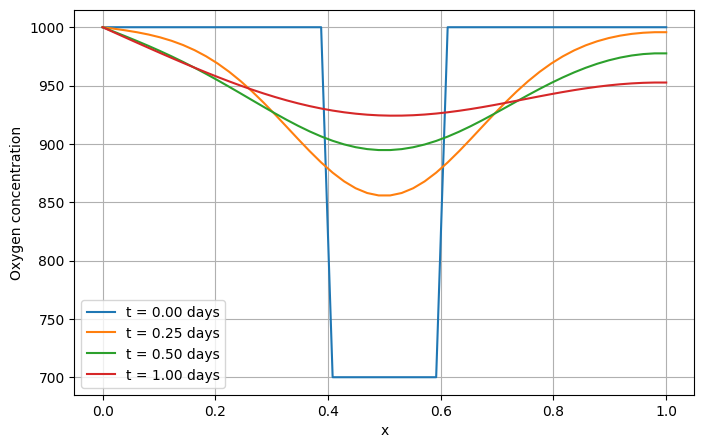

In [2]:
# Steady (healthy) oxygen level from balance: -mu*O + S = 0  -> O = S/mu
O_eq = S / mu

# Initial condition: start is close to equilibrium but with a little disturbance
O_profile = np.full(Nx, O_eq, dtype=float)
O_profile[int(0.4 * Nx):int(0.6 * Nx)] *= 0.7   # 30% drop in the middle (disturbance)

# Boundary conditions
# Left boundary: constant oxygen supply (Dirichlet) consistent with equilibrium
O_left = O_eq

# Right boundary: no-flux (Neumann)
O_profile[0] = O_left
O_profile[-1] = O_profile[-2]

O_history = [O_profile.copy()]

# Explicit time integration (Forward Euler + central differences)
for n in range(Nt):
    O_new = O_profile.copy()

    for i in range(1, Nx - 1):
        laplacian = (O_profile[i - 1] - 2 * O_profile[i] + O_profile[i + 1]) / dx**2
        O_new[i] = O_profile[i] + dt * (D * laplacian - mu * O_profile[i] + S)

    # Enforce boundary conditions each step
    O_new[0] = O_left
    O_new[-1] = O_new[-2]

    O_profile = O_new
    O_history.append(O_profile.copy())

# Plot
plt.figure(figsize=(8, 5))
time_indices = [0, Nt // 4, Nt // 2, Nt]
for idx in time_indices:
    plt.plot(x, O_history[idx], label=f"t = {idx*dt:.2f} days")

plt.xlabel("x")
plt.ylabel("Oxygen concentration")
plt.legend()
plt.grid(True)
plt.show()

To visualise the temporal changes of the system, the simulation was started close to the homogeneous steady state 𝑂=𝑆/𝜇. A localized reduction of oxygen concentration of 30% was introduced in the centre of the domain as an initial disturbance.

Therefore the start is almost uniform with a local deficit. Over time diffusion smooths spatial gradients, while the constant source term restockes oxygen and cellular consumption balances out this increase. As a result, the solution relaxes toward the homogeneous steady state, the local dip becomes wider and the oxygen concentration increases across the tissue again.

# Stability Analysis (Step 7)

Explicit finite difference schemes are conditionally stable, meaning that the choice of the time step \(\Delta t\) relative to the spatial grid size \(\Delta x\) is crucial for stability.For diffusion-dominated problems, the forward Euler scheme combined with central spatial differences is stable only if the time step satisfies a certain restriction.

For the one-dimensional diffusion equation, the stability condition for the explicit finite difference scheme is given by

$$
\Delta t \le \frac{\Delta x^2}{2D}.
$$

In the presence of a linear reaction term, this condition remains a sufficient criterion for stability. In the following, this condition is investigated experimentally by comparing stable and unstable choices of the time step.

To investigate stability experimentally, the numerical solution is computed using two different time step sizes:
- one satisfying the stability condition,
- one exceeding the stability limit.



In [3]:
# Stability limit for explicit diffusion scheme
# Stability limit
dt_lim = dx**2 / (2 * D)

dt_good = 0.5 * dt_lim
dt_bad  = 2.0 * dt_lim
T_test  = 0.2  # physical time to simulate (days)

In [4]:
def run_simulation(dt_test, T_test):
    Nt_test = int(T_test / dt_test)

    # IC: start near steady state with a dip (like Step 6)
    O_eq = S / mu
    O = np.full(Nx, O_eq, dtype=float)
    O[int(0.4*Nx):int(0.6*Nx)] *= 0.7

    # BCs
    O[0] = O_left
    O[-1] = O[-2]

    for _ in range(Nt_test):
        O_new = O.copy()
        for i in range(1, Nx-1):
            lap = (O[i-1] - 2*O[i] + O[i+1]) / dx**2
            O_new[i] = O[i] + dt_test * (D*lap - mu*O[i] + S)

        O_new[0] = O_left
        O_new[-1] = O_new[-2]
        O = O_new

    return O

stable_final = run_simulation(dt_good, T_test)
unstable_final = run_simulation(dt_bad, T_test)

print("dt_lim =", dt_lim, "dt_good =", dt_good, "dt_bad =", dt_bad)
print("stable max/min:", stable_final.max(), stable_final.min())
print("unstable max/min:", unstable_final.max(), unstable_final.min())

dt_lim = 0.004164931278633902 dt_good = 0.002082465639316951 dt_bad = 0.008329862557267803
stable max/min: 1000.0 841.6786619294046
unstable max/min: 4068651919260.959 -3951904600137.5156


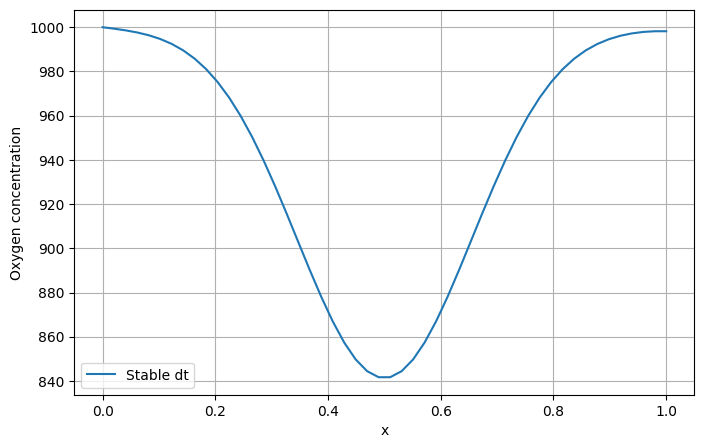

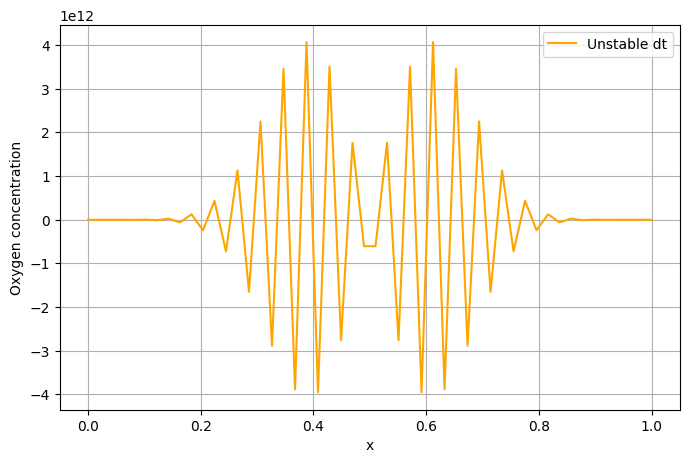

In [5]:
plt.figure(figsize=(8,5))
plt.plot(x, stable_final, label="Stable dt")
plt.xlabel("x"); plt.ylabel("Oxygen concentration")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(x, unstable_final, label="Unstable dt",color="orange")
plt.xlabel("x"); plt.ylabel("Oxygen concentration")
plt.legend(); plt.grid(True); plt.show()


For stability analysis the time stape size was changed while all other parameters stayed fixed. Two simulations were performed:

1. A time step set smaller than the stability limit. In this case the numerical solution remains smooth and the oxygen concentration evolves in a biological meaningful way.

2. Another simulation was chosen with a time step exceeding the stability limit. Here the oscillations are present and demostrate the numerical instability with extrem high magnitudes.



## Play around with different values of the coefficients. (Step 8)



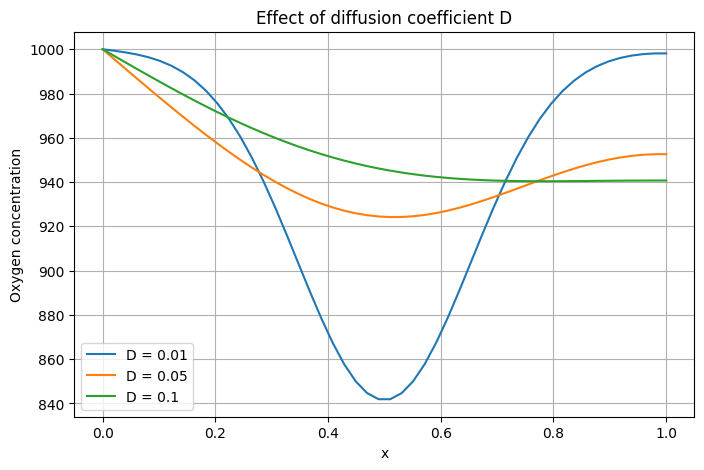

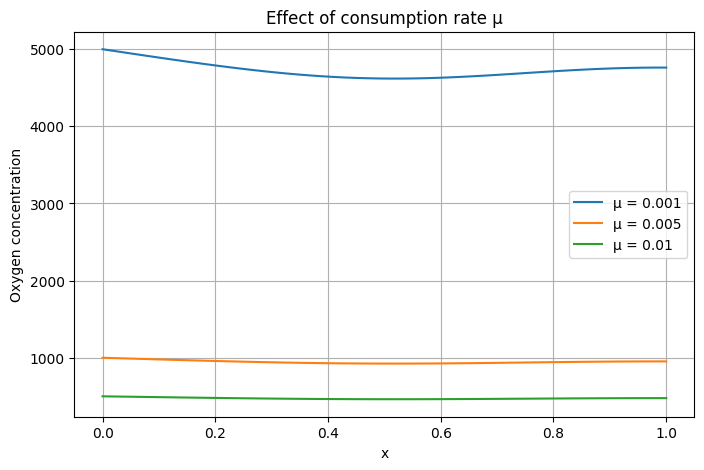

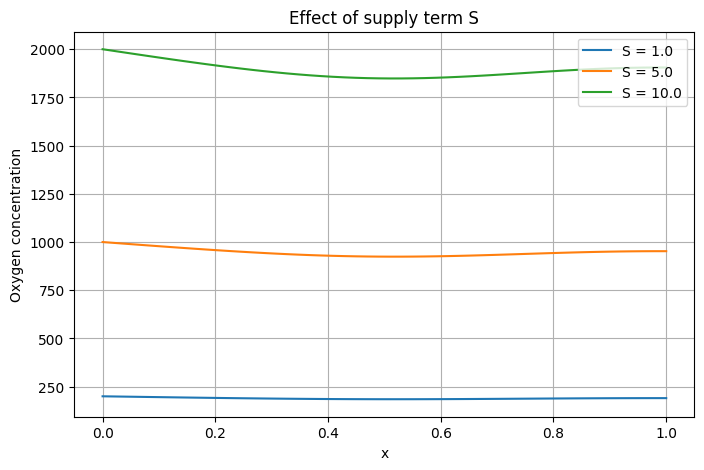

In [9]:
dip_frac = 0.30  # 30% dip in the middle (initial perturbation)

def simulate_profile(D_val, mu_val, S_val):
    O_eq = S_val / mu_val
    profile = np.full(Nx, O_eq, dtype=float)

    # add dip in the middle
    a, b = int(0.4 * Nx), int(0.6 * Nx)
    profile[a:b] *= (1 - dip_frac)

    # boundary conditions
    O_left_local = O_eq
    profile[0] = O_left_local
    profile[-1] = profile[-2]

    for _ in range(Nt):
        new_profile = profile.copy()
        for j in range(1, Nx - 1):
            lap = (profile[j - 1] - 2 * profile[j] + profile[j + 1]) / dx**2
            new_profile[j] = profile[j] + dt * (D_val * lap - mu_val * profile[j] + S_val)

        new_profile[0] = O_left_local
        new_profile[-1] = new_profile[-2]
        profile = new_profile

    return profile


# 1) Effect of diffusion coefficient D

plt.figure(figsize=(8, 5))

for D_val in [0.01, 0.05, 0.10]:
    profile = simulate_profile(D_val, mu, S)
    plt.plot(x, profile, label=f"D = {D_val}")

plt.xlabel("x")
plt.ylabel("Oxygen concentration")
plt.title("Effect of diffusion coefficient D")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------
# 2) Effect of consumption rate mu
# ---------------------------------------------------
plt.figure(figsize=(8, 5))

for mu_val in [0.001, 0.005, 0.010]:
    profile = simulate_profile(D, mu_val, S)
    plt.plot(x, profile, label=f"μ = {mu_val}")

plt.xlabel("x")
plt.ylabel("Oxygen concentration")
plt.title("Effect of consumption rate μ")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------
# 3) Effect of supply term S
# ---------------------------------------------------
plt.figure(figsize=(8, 5))

for S_val in [1.0, 5.0, 10.0]:
    profile = simulate_profile(D, mu, S_val)
    plt.plot(x, profile, label=f"S = {S_val}")

plt.xlabel("x")
plt.ylabel("Oxygen concentration")
plt.title("Effect of supply term S")
plt.legend()
plt.grid(True)
plt.show()

The plots inllustrate the changes of the varying 𝐷, 𝜇 and 𝑆 parameters while keeping the remaining parameters fixed. 

1. Increasing the diffusion coefficient 𝐷 leads to smoother spatial oxygen profiles. For small 𝐷, oxygen spreads slowly and local deficits remain deep.Larger 𝐷 allows oxygen to be located more efficiently which is presented in flatter concentration profiles.
2. Increasing the consumption rate 𝜇 reduces oxygen concentration throughout the tissue, since oxygen is removed more rapidly by cells. Lower values of 𝜇 show reduced metabolic activity, allowing higher oxygen levels to be kept.
3. Increasing the supply term 𝑆 raises the overall oxygen concentration by increasing the equilibrium level 𝑆/𝜇. While the general profile shape looks similar, higher oxygen levels make spatial variations more visibly seen with the curvature.

## Solve the PDE using various schemes and compare them (Step 9).

dt_lim: 0.004164931278633902
dt_exp: 0.002082465639316951 dt_imp: 0.020824656393169508 dt_cn: 0.020824656393169508
max |explicit - implicit|: 3.3630422212199846
max |explicit - CN|: 0.27477527308815297
max |implicit - CN|: 3.0882669481318317


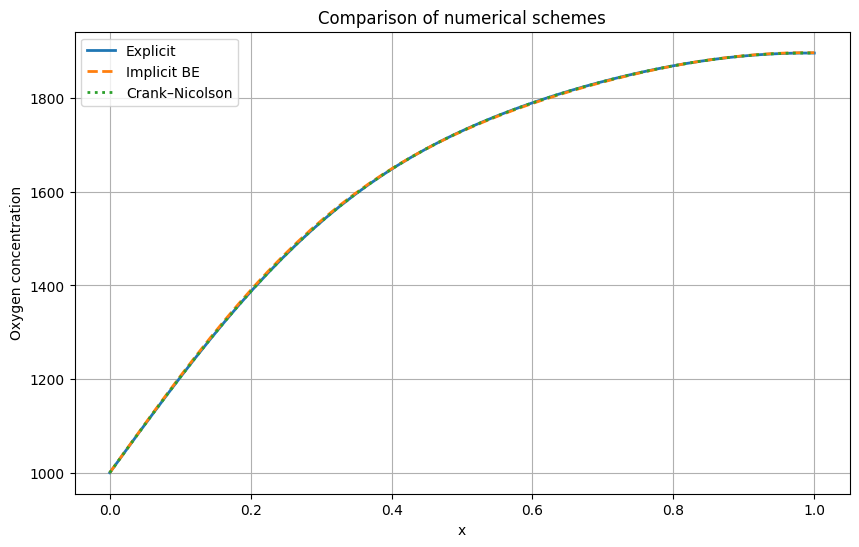

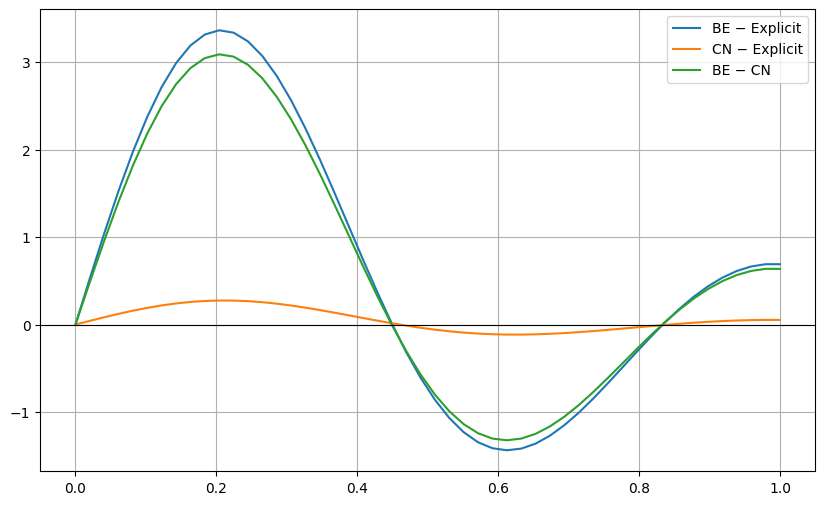

In [17]:
# Initial condition: equilibrium with a dip
O_initial = np.full(Nx, O_eq, dtype=float)
a, b = int(0.4 * Nx), int(0.6 * Nx)
O_initial[a:b] *= 0.7
O_initial[0] = O_left
O_initial[-1] = O_initial[-2]  # no-flux at right


def explicit_scheme(O_init, dt_exp, T_sim):
    Nt_exp = int(T_sim / dt_exp)
    O = O_init.copy()
    for _ in range(Nt_exp):
        O_new = O.copy()
        for i in range(1, Nx - 1):
            lap = (O[i-1] - 2*O[i] + O[i+1]) / dx**2
            O_new[i] = O[i] + dt_exp * (D * lap - mu * O[i] + S)
        O_new[0] = O_left
        O_new[-1] = O_new[-2]
        O = O_new
    return O


def implicit_backward_euler(O_init, dt_imp, T_sim):
    Nt_imp = int(T_sim / dt_imp)
    r = D * dt_imp / dx**2

    A = np.zeros((Nx, Nx))
    bvec = np.zeros(Nx)

    for i in range(1, Nx - 1):
        A[i, i-1] = -r
        A[i, i]   = 1 + 2*r + mu*dt_imp
        A[i, i+1] = -r

    A[0, 0] = 1.0                 # Dirichlet at left
    A[-1, -1] = 1.0               # Neumann at right
    A[-1, -2] = -1.0

    O = O_init.copy()
    for _ in range(Nt_imp):
        bvec[:] = 0.0
        bvec[0] = O_left
        bvec[-1] = 0.0
        for i in range(1, Nx - 1):
            bvec[i] = O[i] + dt_imp * S

        O = np.linalg.solve(A, bvec)

    return O


def crank_nicolson(O_init, dt_cn, T_sim):
    Nt_cn = int(T_sim / dt_cn)
    r = D * dt_cn / dx**2

    A = np.zeros((Nx, Nx))
    B = np.zeros((Nx, Nx))

    for i in range(1, Nx - 1):
        # A matrix (implicit half)
        A[i, i-1] = -0.5 * r
        A[i, i]   = 1 + r + 0.5 * mu * dt_cn
        A[i, i+1] = -0.5 * r

        # B matrix (explicit half)
        B[i, i-1] = 0.5 * r
        B[i, i]   = 1 - r - 0.5 * mu * dt_cn
        B[i, i+1] = 0.5 * r

    A[0, 0] = 1.0      # Dirichlet at left
    B[0, :] = 0.0

    A[-1, -1] = 1.0    # Neumann at right
    A[-1, -2] = -1.0
    B[-1, :]  = 0.0

    O = O_init.copy()
    for _ in range(Nt_cn):
        rhs = B @ O
        rhs[1:Nx-1] += dt_cn * S   # add source once
        rhs[0] = O_left
        rhs[-1] = 0.0
        O = np.linalg.solve(A, rhs)

    return O


# -------------------------------
# Choose different dt for schemes
# -------------------------------
dt_lim = dx**2 / (2 * D)

T_sim = T

dt_exp = 0.5 * dt_lim      # explicit must be <= dt_lim (stable)
dt_imp = 5.0 * dt_lim      # implicit stable even for large dt
dt_cn  = 5.0 * dt_lim      # CN stable for linear diffusion-reaction

O_exp = explicit_scheme(O_initial, dt_exp, T_sim)
O_imp = implicit_backward_euler(O_initial, dt_imp, T_sim)
O_cn  = crank_nicolson(O_initial, dt_cn, T_sim)

print("dt_lim:", dt_lim)
print("dt_exp:", dt_exp, "dt_imp:", dt_imp, "dt_cn:", dt_cn)

print("max |explicit - implicit|:", np.max(np.abs(O_exp - O_imp)))
print("max |explicit - CN|:", np.max(np.abs(O_exp - O_cn)))
print("max |implicit - CN|:", np.max(np.abs(O_imp - O_cn)))

plt.figure(figsize=(10,6))
plt.plot(x, O_exp, label="Explicit", linestyle="-", linewidth=2)
plt.plot(x, O_imp, label="Implicit BE", linestyle="--", linewidth=2)
plt.plot(x, O_cn,  label="Crank–Nicolson", linestyle=":", linewidth=2)
plt.xlabel("x")
plt.ylabel("Oxygen concentration")
plt.title("Comparison of numerical schemes")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, O_imp - O_exp, label="BE − Explicit")
plt.plot(x, O_cn  - O_exp, label="CN − Explicit")
plt.plot(x, O_imp - O_cn,  label="BE − CN")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.grid(True)
plt.show()

Plot 1: Comparison of numerical schemes
All three curves visually overlap and show very similar spatial profiles. It can be concluded that the different numerical methods produce consistent solutions. Although the implicit schemes were computed using a much larger time step than the explicit scheme, the final profiles remain close. This proves the stability of the implicit methods for large time steps, while the explicit method remains stable due to the chosen stability condition time step. The overlap of all curves demostrates that the numerical differences are small compared to the overall oxygen concentration level.


Plot 2: Difference between numerical schemes

To quantify the minor deviations between schemes, a plot of maximum absolute differences was computed. The printed values show:
- \(\max |O_{\mathrm{exp}} - O_{\mathrm{BE}}| = 3.36\), indicating a larger deviation between the explicit and backward Euler solutions due to the stronger numerical diffusion introduced by backward Euler for large time steps.
- \(\max |O_{\mathrm{exp}} - O_{\mathrm{CN}}| = 0.27\), showing that Crank–Nicolson remains much closer to the explicit reference solution, consistent with its higher (second-order) accuracy in time.
- \(\max |O_{\mathrm{BE}} - O_{\mathrm{CN}}| = 3.09\), reflecting the combined effect of backward Euler’s stronger damping compared to Crank–Nicolson’s improved temporal accuracy.

This behavior is also visible in the difference plot, where the Crank–Nicolson explicit curve stays close to zero, while the backward Euler curves show higher deviations. 
